In [237]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [242]:
env_name = "swimmer_v3"
df_name_list = ["df_1_2_3.csv", "df_4_5.csv"]

In [239]:
env_dir = Path(os.getcwd()).parent / env_name
os.chdir(env_dir) 
os.getcwd()

'/home/abenechehab/rl_simulator/benchmark/swimmer_v3'

In [240]:
def effective_horizon(horizon: int, beta: float):
    eff_hor = 0.0
    for i in range(1,horizon+1):
        eff_hor += (beta ** i) * i
    return eff_hor / sum([beta ** i for i in range(1, horizon+1)])

In [243]:
df_list = []
for df_name in df_name_list:
    df_list.append(pd.read_csv(f'artifacts/{df_name}', index_col=0))
df = pd.concat(df_list, axis=0)
df

,fold,epoch,loss_horizon,beta,train_loss,valid_loss,max_grad_train,max_grad_test,max_grad_random,spectral,...,r2_test_h_89,r2_test_h_90,r2_test_h_91,r2_test_h_92,r2_test_h_93,r2_test_h_94,r2_test_h_95,r2_test_h_96,r2_test_h_97,r2_test_h_98
0,1,1,1,1.0,0.158544,0.007990,0.001016,0.008815,0.008734,291.595917,...,0.294287,0.293825,0.293660,0.293740,0.293972,0.294175,0.294248,0.294474,0.294753,0.295192
0,1,2,1,1.0,0.006191,0.004641,0.001284,0.010056,0.009737,287.935242,...,0.601101,0.601668,0.601871,0.602056,0.602494,0.603018,0.603635,0.604293,0.605045,0.606037
0,1,3,1,1.0,0.004647,0.003043,0.001426,0.008193,0.009141,287.069550,...,0.783484,0.783831,0.783908,0.783856,0.783548,0.783159,0.782355,0.781582,0.780590,0.779703
0,1,4,1,1.0,0.003348,0.010086,0.001137,0.010232,0.010684,284.787323,...,0.538306,0.537542,0.536736,0.535889,0.534990,0.534083,0.533266,0.532412,0.531739,0.531304
0,1,5,1,1.0,0.003441,0.002605,0.001233,0.012733,0.016006,289.758942,...,0.669734,0.669330,0.669130,0.668845,0.668686,0.668396,0.667924,0.667341,0.666740,0.666352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3,296,5,10.0,0.000881,0.001551,0.002027,0.011508,0.017317,2107.551514,...,0.730688,0.728439,0.726263,0.724213,0.722445,0.720071,0.717692,0.715389,0.713396,0.711384
0,3,297,5,10.0,0.000885,0.001543,0.002048,0.013117,0.013353,2108.360107,...,0.699687,0.697223,0.695005,0.692789,0.690643,0.688374,0.686302,0.684166,0.682331,0.680529
0,3,298,5,10.0,0.000914,0.001862,0.002162,0.010786,0.016441,2106.117920,...,0.740693,0.739374,0.738127,0.736826,0.735379,0.733459,0.731423,0.729696,0.728328,0.727040
0,3,299,5,10.0,0.000924,0.001541,0.002151,0.013159,0.018483,2107.555176,...,0.727223,0.724988,0.722516,0.720265,0.717994,0.715283,0.712494,0.710128,0.708131,0.706237


In [244]:
df['beta'].unique()

array([ 1.  ,  0.1 ,  0.25,  0.5 ,  5.  , 10.  ])

## loss horizon / beta / epoch / lipschitz of best R2 test models = f(prediction horizon)

In [245]:
# sub_df = df.loc[df['loss_horizon']==2].copy()
sub_df = df.copy()
# Assuming 'df' is your DataFrame containing the model metrics and R^2 scores

# Step 1: Aggregate R^2 scores across folds
r2_columns = [col for col in sub_df.columns if col.startswith('r2_test_h_')]
agg_columns = ['loss_horizon', 'beta', 'epoch'] + r2_columns
aggregated_scores = sub_df.groupby(['loss_horizon', 'beta', 'epoch'])[r2_columns].mean().reset_index()
aggregated_scores_std = sub_df.groupby(['loss_horizon', 'beta', 'epoch'])[r2_columns].std().reset_index()

# Step 2: Identify the best model for each prediction horizon based on mean R^2 scores
best_models_mean = []
for r2_col in r2_columns:
    idx = aggregated_scores[r2_col].idxmax()
    best_row = aggregated_scores.loc[idx]
    best_row_std = aggregated_scores_std.loc[idx]
    best_models_mean.append({
        'horizon': r2_col,
        'loss_horizon': best_row['loss_horizon'],
        'beta': best_row['beta'],
        'epoch': best_row['epoch'],
        'mean_r2_score': best_row[r2_col],
        'std_r2_score': best_row_std[r2_col]
    })

# Since we need the Lipschitz constant metrics for these best models, let's match these back in the original df
for model in best_models_mean:
    metrics = sub_df[(sub_df['loss_horizon'] == model['loss_horizon']) &
                 (sub_df['beta'] == model['beta']) &
                 (sub_df['epoch'] == model['epoch'])].iloc[0]
    model.update({
        'max_grad_train': metrics['max_grad_train'],
        'max_grad_test': metrics['max_grad_test'],
        'max_grad_random': metrics['max_grad_random'],
        'spectral': metrics['spectral']
    })

# Convert the list of best models based on mean R^2 scores into a DataFrame
best_models_mean_df = pd.DataFrame(best_models_mean)

# Add a numerical horizon column for potential plotting or analysis
best_models_mean_df['horizon_num'] = best_models_mean_df['horizon'].apply(lambda x: int(x.split('_')[-1]))

rows = []
for i in range(len(best_models_mean_df)):
    row = pd.DataFrame(best_models_mean_df.iloc[i]).T
    row['effective_horizon'] = effective_horizon(horizon=int(row['loss_horizon']), beta=float(row['beta']))
    rows.append(row)
best_models_mean_df = pd.concat(rows, axis=0)

# Display the first few rows of the DataFrame
best_models_mean_df

,horizon,loss_horizon,beta,epoch,mean_r2_score,std_r2_score,max_grad_train,max_grad_test,max_grad_random,spectral,horizon_num,effective_horizon
0,r2_test_h_1,4.0,0.1,37.0,0.92324,0.002584,0.00276,0.013267,0.014309,690.520325,1,1.110711
1,r2_test_h_2,2.0,0.25,133.0,0.919201,0.002661,0.004788,0.014633,0.022438,1505.171997,2,1.200000
2,r2_test_h_3,2.0,0.25,165.0,0.915408,0.004004,0.004382,0.016976,0.028552,1566.277832,3,1.200000
3,r2_test_h_4,2.0,0.25,165.0,0.911559,0.005572,0.004382,0.016976,0.028552,1566.277832,4,1.200000
4,r2_test_h_5,5.0,0.5,205.0,0.908057,0.001971,0.00273,0.011978,0.015185,1418.423584,5,1.838710
...,...,...,...,...,...,...,...,...,...,...,...,...
93,r2_test_h_94,4.0,5.0,139.0,0.819462,0.011001,0.003186,0.016078,0.041259,3150.803955,94,3.756410
94,r2_test_h_95,4.0,5.0,139.0,0.819191,0.0111,0.003186,0.016078,0.041259,3150.803955,95,3.756410
95,r2_test_h_96,4.0,5.0,139.0,0.818936,0.011282,0.003186,0.016078,0.041259,3150.803955,96,3.756410
96,r2_test_h_97,4.0,5.0,139.0,0.818574,0.011444,0.003186,0.016078,0.041259,3150.803955,97,3.756410


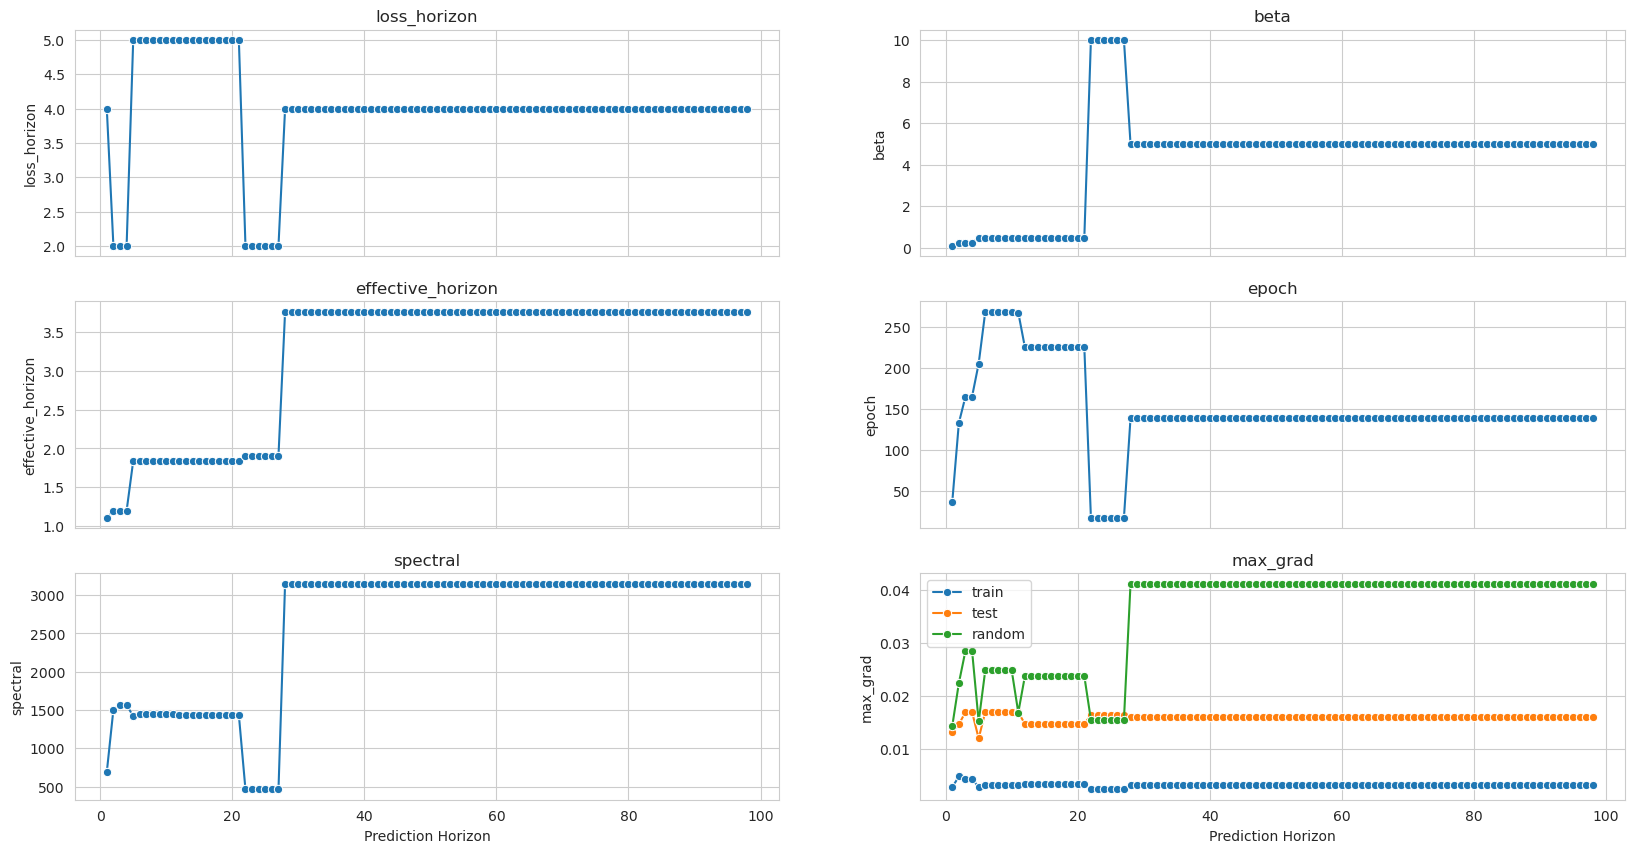

In [246]:
# Assuming best_models_mean_df is the DataFrame containing the best models and their Lipschitz constants

# Setting up the plotting environment
sns.set_style("whitegrid")

metrics = ['loss_horizon', 'beta', 'effective_horizon', 'epoch', 'spectral', 'max_grad']

f, axes = plt.subplots(3, 2, figsize=(20, 10), sharex=True)
axes = list(np.array(axes).flatten())

for i, metric in enumerate(metrics):
    ax=axes[i]
    if metric == 'max_grad':
        sns.lineplot(data=best_models_mean_df, x='horizon_num', y=f'{metric}_train', marker='o', linestyle='-', label='train', ax=ax)
        sns.lineplot(data=best_models_mean_df, x='horizon_num', y=f'{metric}_test', marker='o', linestyle='-', ax=ax, label='test')
        sns.lineplot(data=best_models_mean_df, x='horizon_num', y=f'{metric}_random', marker='o', linestyle='-', ax=ax, label='random') 
    else:
        sns.lineplot(data=best_models_mean_df, x='horizon_num', y=metric, marker='o', linestyle='-', ax=ax)
    
    ax.set_xlabel('Prediction Horizon')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.grid(True)
    if metric == 'max_grad':
        ax.legend()
plt.show()

## Oracle best R2(h) curve

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

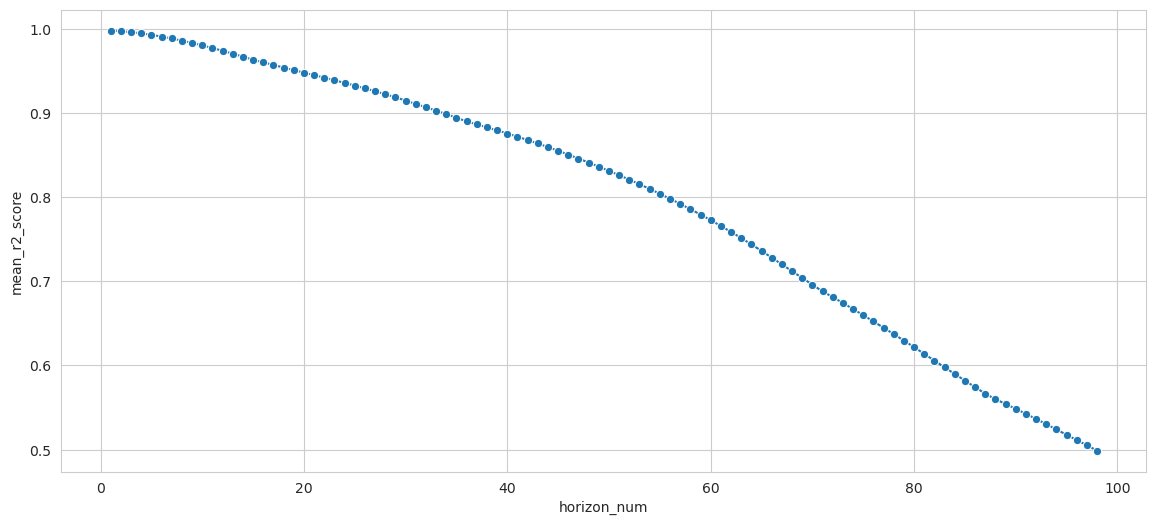

In [232]:
# Assuming best_models_mean_df is the DataFrame containing the best models and their Lipschitz constants

# Setting up the plotting environment
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

sns.lineplot(data=best_models_mean_df, x='horizon_num', y='mean_r2_score', marker='o', linestyle='-')
ax.fill_between(
    best_models_mean_df['horizon_num'], 
    best_models_mean_df['mean_r2_score'] - best_models_mean_df['std_r2_score'], 
    best_models_mean_df['mean_r2_score'] + best_models_mean_df['std_r2_score']
)
plt.xlabel('Prediction Horizon')
plt.ylabel('Spectral Norm')
plt.title('Spectral Norms of Best Models Across Prediction Horizons')
plt.grid(True)

plt.show()

## R2 = f(h)

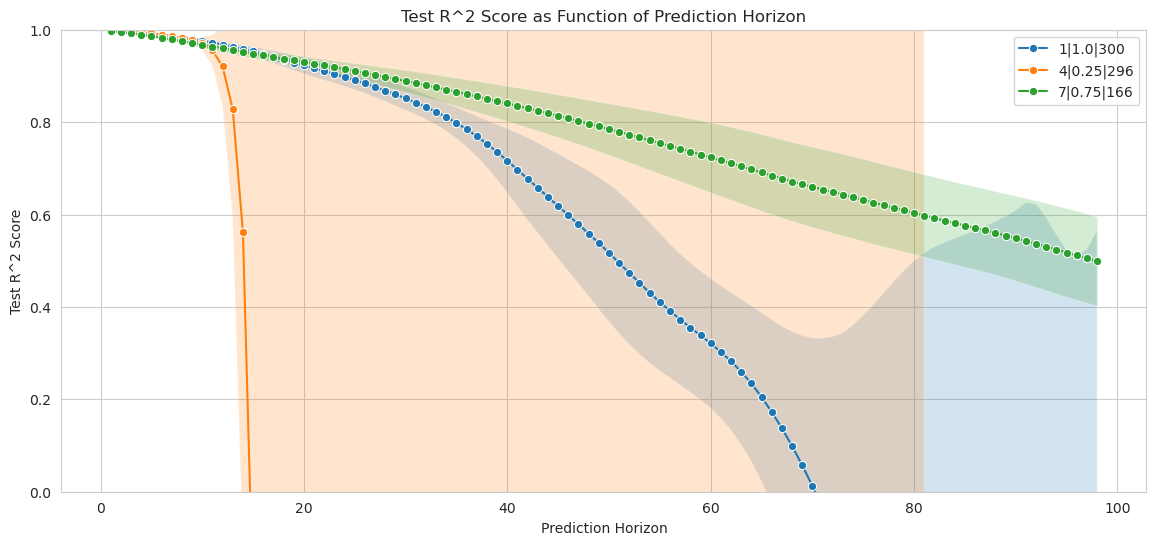

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(14, 6))

max_pred_horizon = 100

d = [
    [1, 1.0, 300],
    [4, 0.25, 296],
    [7, 0.75, 166]
]

y_lim = 1

for e in d:
    specified_loss_horizon = e[0]
    specified_beta = e[1]     
    specified_epoch = e[2]
    
    filtered_df = df[
        (df['loss_horizon'] == specified_loss_horizon) & 
        (df['beta'] == specified_beta) & 
        (df['epoch'] == specified_epoch)
    ]
    
    mean_r2_scores = filtered_df[[col for col in filtered_df.columns if col.startswith('r2_test_h_')]].mean()
    std_r2_scores = filtered_df[[col for col in filtered_df.columns if col.startswith('r2_test_h_')]].std()
    
    # Preparing data for plotting
    horizons = [int(col.split('_')[-1]) for col in mean_r2_scores.index]
    mean_scores = mean_r2_scores.values
    std_scores = std_r2_scores.values
    
    # # Plotting
    sns.lineplot(x=horizons[:max_pred_horizon], y=mean_scores[:max_pred_horizon], marker='o', linestyle='-', 
                 label=f'{specified_loss_horizon}|{specified_beta}|{specified_epoch}')
    plt.fill_between(
        horizons[:max_pred_horizon], 
        mean_scores[:max_pred_horizon] - std_scores[:max_pred_horizon], 
        mean_scores[:max_pred_horizon] + std_scores[:max_pred_horizon], alpha=0.2)

    if np.min(mean_scores[:max_pred_horizon]) < y_lim:
        y_lim = np.min(mean_scores[:max_pred_horizon])

plt.xlabel('Prediction Horizon')
plt.ylabel('Test R^2 Score')
plt.title(f'Test R^2 Score as Function of Prediction Horizon')
plt.grid(True)

plt.legend()
plt.ylim([max(0,y_lim),1])

plt.show()

## cumulative R2

In [234]:
sub_df = df.loc[df['loss_horizon']==2].copy()
sub_df = df.copy()
# Assuming 'df' is your DataFrame containing the model metrics and R^2 scores

# Step 1: Aggregate R^2 scores across folds
r2_columns = [col for col in sub_df.columns if col.startswith('r2_test_h_')]

sub_df[r2_columns] = sub_df[r2_columns].cumsum(axis=1) / np.repeat(np.arange(1,99)[None,...], len(sub_df), axis=0)

agg_columns = ['loss_horizon', 'beta', 'epoch'] + r2_columns
aggregated_scores = sub_df.groupby(['loss_horizon', 'beta', 'epoch'])[r2_columns].mean().reset_index()
aggregated_scores_std = sub_df.groupby(['loss_horizon', 'beta', 'epoch'])[r2_columns].std().reset_index()

# Step 2: Identify the best model for each prediction horizon based on mean R^2 scores
best_models_mean = []
for r2_col in r2_columns:
    idx = aggregated_scores[r2_col].idxmax()
    best_row = aggregated_scores.loc[idx]
    best_row_std = aggregated_scores_std.loc[idx]
    best_models_mean.append({
        'horizon': r2_col,
        'loss_horizon': best_row['loss_horizon'],
        'beta': best_row['beta'],
        'epoch': best_row['epoch'],
        'mean_r2_score': best_row[r2_col],
        'std_r2_score': best_row_std[r2_col]
    })

# Since we need the Lipschitz constant metrics for these best models, let's match these back in the original df
for model in best_models_mean:
    metrics = sub_df[(sub_df['loss_horizon'] == model['loss_horizon']) &
                 (sub_df['beta'] == model['beta']) &
                 (sub_df['epoch'] == model['epoch'])].iloc[0]
    model.update({
        'max_grad_train': metrics['max_grad_train'],
        'max_grad_test': metrics['max_grad_test'],
        'max_grad_random': metrics['max_grad_random'],
        'spectral': metrics['spectral']
    })

# Convert the list of best models based on mean R^2 scores into a DataFrame
best_models_mean_df = pd.DataFrame(best_models_mean)

# Add a numerical horizon column for potential plotting or analysis
best_models_mean_df['horizon_num'] = best_models_mean_df['horizon'].apply(lambda x: int(x.split('_')[-1]))

rows = []
for i in range(len(best_models_mean_df)):
    row = pd.DataFrame(best_models_mean_df.iloc[i]).T
    row['effective_horizon'] = effective_horizon(horizon=int(row['loss_horizon']), beta=float(row['beta']))
    rows.append(row)
best_models_mean_df = pd.concat(rows, axis=0)

# Display the first few rows of the DataFrame
best_models_mean_df

,horizon,loss_horizon,beta,epoch,mean_r2_score,std_r2_score,max_grad_train,max_grad_test,max_grad_random,spectral,horizon_num,effective_horizon
0,r2_test_h_1,4.0,0.25,296.0,0.99784,0.00006,0.004082,0.002133,0.002205,67.463989,1,1.317647
1,r2_test_h_2,4.0,0.25,296.0,0.997453,0.000109,0.004082,0.002133,0.002205,67.463989,2,1.317647
2,r2_test_h_3,4.0,0.25,296.0,0.996927,0.000168,0.004082,0.002133,0.002205,67.463989,3,1.317647
3,r2_test_h_4,6.0,0.5,294.0,0.996305,0.000124,0.001547,0.001057,0.000989,45.347202,4,1.904762
4,r2_test_h_5,6.0,0.5,294.0,0.995593,0.000156,0.001547,0.001057,0.000989,45.347202,5,1.904762
...,...,...,...,...,...,...,...,...,...,...,...,...
93,r2_test_h_94,9.0,0.75,261.0,0.804432,0.0252,0.001557,0.000447,0.000523,32.48027,94,3.269379
94,r2_test_h_95,9.0,0.75,261.0,0.80111,0.025648,0.001557,0.000447,0.000523,32.48027,95,3.269379
95,r2_test_h_96,9.0,0.75,261.0,0.797769,0.026093,0.001557,0.000447,0.000523,32.48027,96,3.269379
96,r2_test_h_97,9.0,0.75,229.0,0.794543,0.028999,0.001537,0.000447,0.000471,31.364532,97,3.269379


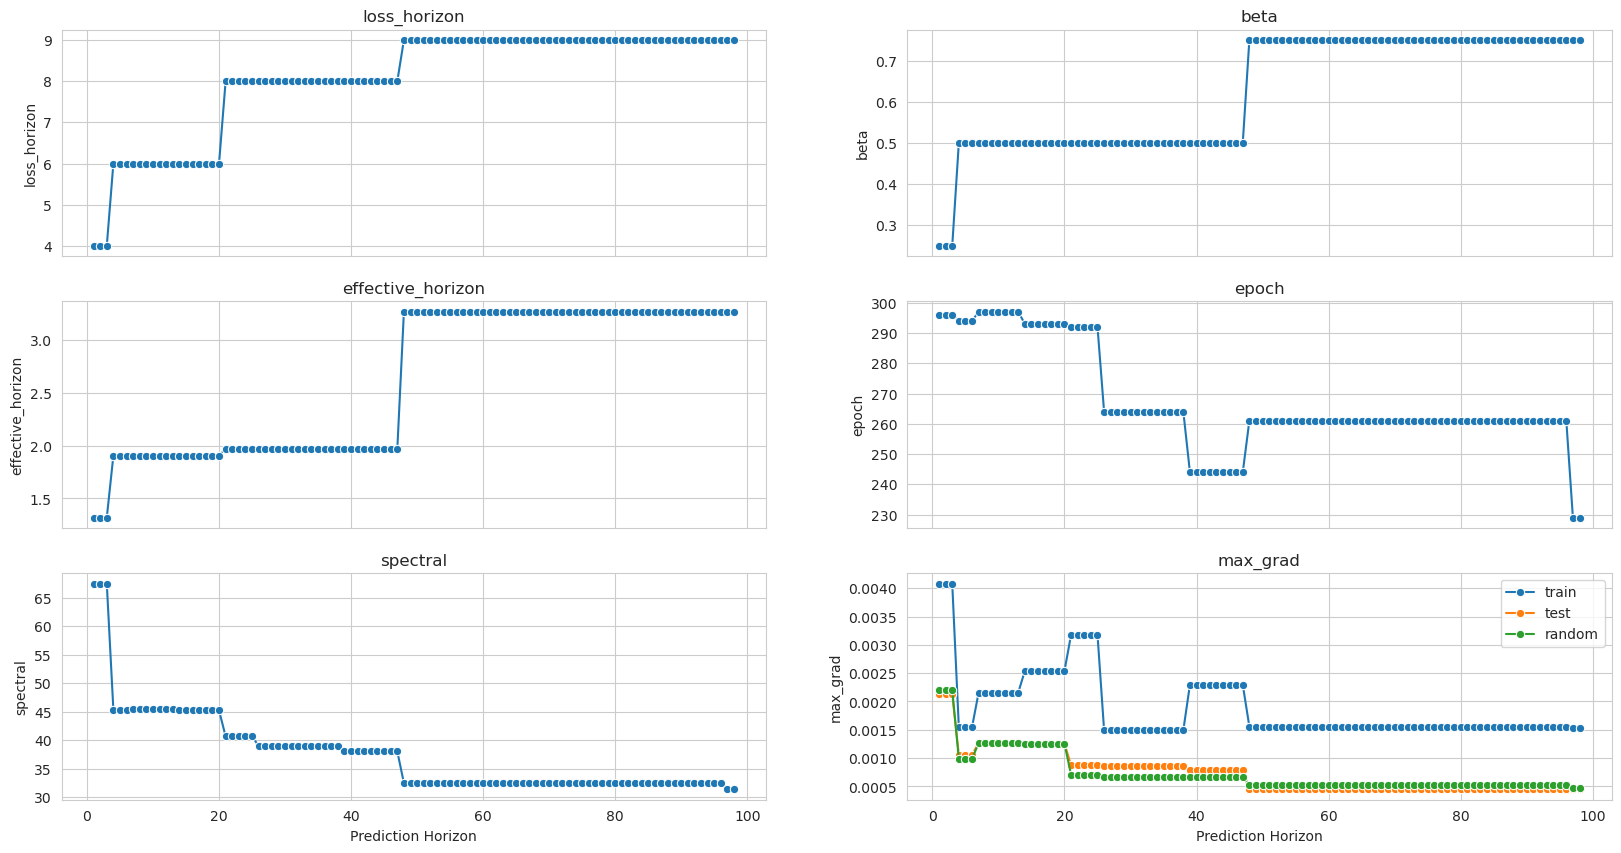

In [235]:
# Assuming best_models_mean_df is the DataFrame containing the best models and their Lipschitz constants

# Setting up the plotting environment
sns.set_style("whitegrid")

metrics = ['loss_horizon', 'beta', 'effective_horizon', 'epoch', 'spectral', 'max_grad']

f, axes = plt.subplots(3, 2, figsize=(20, 10), sharex=True)
axes = list(np.array(axes).flatten())

for i, metric in enumerate(metrics):
    ax=axes[i]
    if metric == 'max_grad':
        sns.lineplot(data=best_models_mean_df, x='horizon_num', y=f'{metric}_train', marker='o', linestyle='-', label='train', ax=ax)
        sns.lineplot(data=best_models_mean_df, x='horizon_num', y=f'{metric}_test', marker='o', linestyle='-', ax=ax, label='test')
        sns.lineplot(data=best_models_mean_df, x='horizon_num', y=f'{metric}_random', marker='o', linestyle='-', ax=ax, label='random') 
    else:
        sns.lineplot(data=best_models_mean_df, x='horizon_num', y=metric, marker='o', linestyle='-', ax=ax)
    
    ax.set_xlabel('Prediction Horizon')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.grid(True)
    if metric == 'max_grad':
        ax.legend()
plt.show()

## R2 = f(h) - again

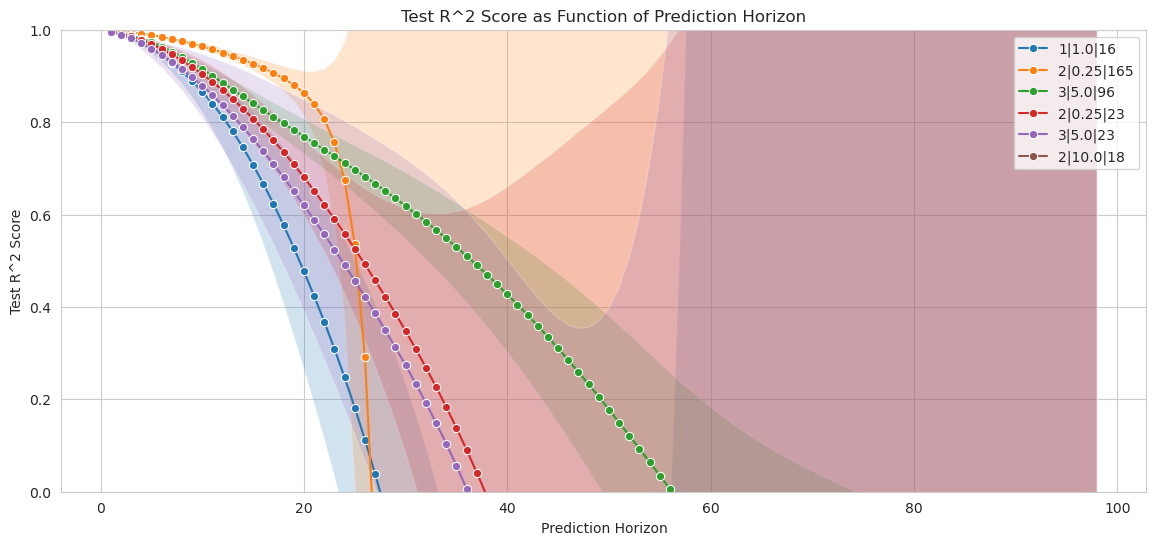

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(14, 6))

max_pred_horizon = 100

d = [
    [1, 1.0, 16],
    [2, 0.25, 165],
    [3, 5.0, 96],
    [2, 0.25, 23],
    [3, 5.0, 23],
    [2, 10.0, 18],
]

y_lim = 1

for e in d:
    specified_loss_horizon = e[0]
    specified_beta = e[1]     
    specified_epoch = e[2]
    
    filtered_df = df[
        (df['loss_horizon'] == specified_loss_horizon) & 
        (df['beta'] == specified_beta) & 
        (df['epoch'] == specified_epoch)
    ]
    
    mean_r2_scores = filtered_df[[col for col in filtered_df.columns if col.startswith('r2_test_h_')]].mean()
    std_r2_scores = filtered_df[[col for col in filtered_df.columns if col.startswith('r2_test_h_')]].std()
    
    # Preparing data for plotting
    horizons = [int(col.split('_')[-1]) for col in mean_r2_scores.index]
    mean_scores = mean_r2_scores.values
    std_scores = std_r2_scores.values
    
    # # Plotting
    sns.lineplot(x=horizons[:max_pred_horizon], y=mean_scores[:max_pred_horizon], marker='o', linestyle='-', 
                 label=f'{specified_loss_horizon}|{specified_beta}|{specified_epoch}')
    plt.fill_between(
        horizons[:max_pred_horizon], 
        mean_scores[:max_pred_horizon] - std_scores[:max_pred_horizon], 
        mean_scores[:max_pred_horizon] + std_scores[:max_pred_horizon], alpha=0.2)

    if np.min(mean_scores[:max_pred_horizon]) < y_lim:
        y_lim = np.min(mean_scores[:max_pred_horizon])

plt.xlabel('Prediction Horizon')
plt.ylabel('Test R^2 Score')
plt.title(f'Test R^2 Score as Function of Prediction Horizon')
plt.grid(True)

plt.legend()
plt.ylim([max(0,y_lim),1])

plt.show()

## Lip = f(loss_horizon, beta)

In [ ]:
epoch = 300
fold = 1
for lip_c in ['max_grad_train', 'max_grad_test', 'max_grad_random', 'spectral']:
    lip_df_pivot = df.loc[(df['epoch']==epoch) & (df['fold']==fold)].pivot(index="loss_horizon", columns="beta", values=lip_c)
    plt.figure()
    ax = sns.heatmap(lip_df_pivot, annot=True)
    ax.set_title(lip_c)
    # plt.savefig(f"artifacts/{lip_c}_{epoch}.jpg")
plt.show()

## Lip = f(epoch)

In [ ]:
loss_horizon = [1, 2]
beta = [1.0, 0.1]
for lip_c in ['max_grad_train', 'max_grad_test', 'max_grad_random', 'spectral']:
    plt.figure()
    ax = sns.lineplot(
        data=df.loc[(df['loss_horizon'].isin(loss_horizon)) & (df['beta'].isin(beta))], 
        x='epoch', y=lip_c, hue='loss_horizon', style='beta'
    )
    ax.set_title(lip_c)
    # plt.savefig(f"artifacts/{lip_c}_{epoch}.jpg")
plt.show()